In [1]:
# Importamos librerías
import requests
from bs4 import BeautifulSoup
import pandas as pd
import html
import numpy as np
import lxml

In [2]:
# Accedemos al contenido de cada página (elecciones 2021 y 2019) de cada municipio (desde el 01 al 173)
count_muni = 1
list_muni = []
lista_fallos = []
while count_muni <184:
    try:
        # coletilla
        if len(str(count_muni)) == 1:
            muniID = '0' + str(count_muni)
        else:
            muniID = str(count_muni)
        col =  muniID+'.xml2'
        
        # Se crea la lista donde se guardarán los datos de cada municipio 
        datos_muni = []

        # Se generan los accesos a las páginas web donde se alojan los datos (una versión para las elecciones de 2019 y otra para las de 2021)
        # 2021
        URL_2021 = 'https://rsl00.epimg.net/elecciones/2021/autonomicas/12/28/' + col
        r_2021 = requests.get (URL_2021)
        soup_2021 = BeautifulSoup(r_2021.text, 'lxml')
        #2019
        URL_2019 = 'https://rsl00.epimg.net/elecciones/2019/autonomicas/12/28/' + col
        r_2019 = requests.get (URL_2019)
        soup_2019 = BeautifulSoup(r_2019.text, 'lxml')

        # Se obtienen e insertan los datos de cabecera de cada municipio: 
        # ID, Nombre Municipio, Votos contabilizados, nulos y abstenciones, por año y con la variación entre elecciones (Delta) 
        # se inserta el código postal del municipio creado a partir del contador del bucle
        if len(str(muniID)) == 2:
            CPmuni = '280' + str(muniID)
        else:
            CPmuni = '28' + str(muniID)
        datos_muni.append(int(CPmuni))
        datos_muni.append(soup_2021.find('nombre_sitio').text)


        #Contabilizados
        conta_2021 =  float(soup_2021.find('votos').find('contabilizados').find('porcentaje').text)
        datos_muni.append(conta_2021)
        conta_2019 =  float(soup_2019.find('votos').find('contabilizados').find('porcentaje').text)
        datos_muni.append(conta_2019)
        delta_conta = round(conta_2021 -conta_2019, 2)
        datos_muni.append(delta_conta)

        # Abstenciones
        abst_2021 =  float(soup_2021.find('votos').find('abstenciones').find('porcentaje').text)
        datos_muni.append(abst_2021)
        abst_2019 =  float(soup_2019.find('votos').find('abstenciones').find('porcentaje').text)
        datos_muni.append(abst_2019)
        delta_abst = round(abst_2021 -abst_2019, 2)
        datos_muni.append(delta_abst)

        #Nulos
        nulos_2021 =  float(soup_2021.find('votos').find('nulos').find('porcentaje').text)
        datos_muni.append(nulos_2021)
        nulos_2019 =  float(soup_2019.find('votos').find('nulos').find('porcentaje').text)
        datos_muni.append(nulos_2019)
        delta_nulos = round(nulos_2021 -nulos_2019, 2)
        datos_muni.append(delta_nulos)

        # Blancos
        blc_2021 =  float(soup_2021.find('votos').find('blancos').find('porcentaje').text)
        datos_muni.append(blc_2021)
        blc_2019 =  float(soup_2019.find('votos').find('blancos').find('porcentaje').text)
        datos_muni.append(blc_2019)
        delta_blc = round(blc_2021 -blc_2019, 2)
        datos_muni.append(delta_blc)

        # Se genera el cuerpo central de la línea del municipio:
        # con los valores de los votos (y los deltas) de los partidos más relevantes: PP, PSOE, MÁS MADRID, PODEMOS-IU, VOX y Cs
        # Para ello se crean dos diccionarios auxiliares que filtran aquellos partidos que no son interesantes y servirán de base para generar 
        # un único diccionario con los datos de los partidos políticos relevantes del municipio
        partidos_2021 = soup_2021.find('resultados').find_all('partido') 
        dict_Municipio_2021 = {}
        for partido in partidos_2021:
            nombre_partido = partido.find('nombre').text
            if nombre_partido in ['PP','PSOE', 'MÁS MADRID', 'PODEMOS-IU', 'VOX', 'Cs']:
                porcentaje_partido = float(partido.find('votos_porciento').text)
                dict_Municipio_2021[nombre_partido] = porcentaje_partido
        dict_Municipio_2021

        partidos_2019 = soup_2019.find('resultados').find_all('partido') 
        dict_Municipio_2019 = {}
        for partido in partidos_2019:
            nombre_partido = partido.find('nombre').text
            if nombre_partido in ['PP','PSOE', 'MÁS MADRID', 'PODEMOS-IU', 'VOX', 'Cs']:
                porcentaje_partido = float(partido.find('votos_porciento').text)
                dict_Municipio_2019[nombre_partido] = porcentaje_partido
        dict_Municipio_2019

        # Después de filtrar los partidos relevantes se genera un diccionario con los votos de ambas elecciones y el Delta entre ellas
        dict_partidos = {}
        for key in dict_Municipio_2021:
            try:
                dict_partidos[key] = [dict_Municipio_2021[key], dict_Municipio_2019[key], round(dict_Municipio_2021[key] - dict_Municipio_2019[key],2)]
            except:
                continue

        # Se insertan los datos de los partidos siempre en el mismo orden 
        # PP: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['PP'][0])
            datos_muni.append(dict_partidos['PP'][1])
            datos_muni.append(dict_partidos['PP'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)

        # PSOE: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['PSOE'][0])
            datos_muni.append(dict_partidos['PSOE'][1])
            datos_muni.append(dict_partidos['PSOE'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)

        # MÁS MADRID: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['MÁS MADRID'][0])
            datos_muni.append(dict_partidos['MÁS MADRID'][1])
            datos_muni.append(dict_partidos['MÁS MADRID'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)

        # PODEMOS-IU: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['PODEMOS-IU'][0])
            datos_muni.append(dict_partidos['PODEMOS-IU'][1])
            datos_muni.append(dict_partidos['PODEMOS-IU'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)

        # VOX: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['VOX'][0])
            datos_muni.append(dict_partidos['VOX'][1])
            datos_muni.append(dict_partidos['VOX'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)


        # Cs: votos 2021, votos 2019, Delta
        try:
            datos_muni.append(dict_partidos['Cs'][0])
            datos_muni.append(dict_partidos['Cs'][1])
            datos_muni.append(dict_partidos['Cs'][2])
        except:
            datos_muni.append(0)
            datos_muni.append(0)
            datos_muni.append(0)

        # se meten los datos en una lista
        list_muni.append(datos_muni)

        count_muni += 1
    except:
        lista_fallos.append(count_muni)
        count_muni += 1

# Se genera el dataframe con todos los datos recolectados así como las columnas que corresponden
df_votos_muni = pd.DataFrame(list_muni, columns=['CP', 'Municipio', 'Cont-2021', 'Cont-2019','D-Cont', 'Abst-2021', 'Abst-2019','D-Abst', 'Blc-2021', 'Blc-2019','D-Blc', 'Nul-2021', 'Nul-2019','D-Nul', 'PP-2021', 'PP-2019', 'D-PP', 'PSOE-2021', 'PSOE-2019', 'D-PSOE', 'MÁS MADRID-2021', 'MÁS MADRID-2019', 'D-MÁS MADRID', 'PODEMOS-IU-2021', 'PODEMOS-IU-2019', 'D-PODEMOS-IU', 'VOX-2021', 'VOX-2019', 'D-VOX', 'Cs-2021', 'Cs-2019', 'D-Cs'])
df_votos_muni

,CP,Municipio,Cont-2021,Cont-2019,D-Cont,Abst-2021,Abst-2019,D-Abst,Blc-2021,Blc-2019,...,D-MÁS MADRID,PODEMOS-IU-2021,PODEMOS-IU-2019,D-PODEMOS-IU,VOX-2021,VOX-2019,D-VOX,Cs-2021,Cs-2019,D-Cs
0,28001,La Acebeda,82.35,90.91,-8.56,17.65,9.09,8.56,2.38,4.29,...,-7.61,14.63,7.46,7.17,2.44,2.99,-0.55,2.44,20.90,-18.46
1,28002,Ajalvir,71.95,66.34,5.61,28.05,33.66,-5.61,0.64,0.55,...,3.86,4.35,3.74,0.61,14.63,12.65,1.98,2.41,21.05,-18.64
2,28003,Alameda del Valle,86.15,82.84,3.31,13.85,17.16,-3.31,0.00,0.00,...,12.86,6.55,2.14,4.41,9.52,5.71,3.81,4.17,13.57,-9.40
3,28004,El Álamo,70.77,65.01,5.76,29.23,34.99,-5.76,0.90,0.61,...,3.08,6.34,5.57,0.77,15.38,12.67,2.71,1.96,15.90,-13.94
4,28005,Alcalá de Henares,74.12,65.71,8.41,25.88,34.29,-8.41,0.78,0.48,...,3.20,7.01,5.96,1.05,9.72,9.09,0.63,3.59,20.34,-16.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,28179,Villar del Olmo,74.54,65.33,9.21,25.46,34.67,-9.21,0.77,0.21,...,1.77,7.27,5.61,1.66,14.10,12.92,1.18,2.51,18.54,-16.03
172,28180,Villarejo de Salvanés,76.01,73.20,2.81,23.99,26.80,-2.81,0.87,0.98,...,5.73,5.54,3.82,1.72,10.21,6.84,3.37,3.67,21.83,-18.16
173,28181,Villaviciosa de Odón,82.34,72.93,9.41,17.66,27.07,-9.41,0.44,0.39,...,0.48,3.86,3.48,0.38,11.14,13.00,-1.86,3.52,22.70,-19.18
174,28182,Villavieja del Lozoya,80.26,82.32,-2.06,19.74,17.68,2.06,0.00,0.00,...,11.91,8.74,9.82,-1.08,8.74,9.82,-1.08,2.19,14.11,-11.92


In [3]:
# se obtiene la población de los ficheros descargados del INE (población total y por sexos) para generar un único dataframe e insertarlo en el dataframe con los datos de votación

# Procesado del fichero con la población total
df_pop2021_T = pd.read_csv('pob_muni_INE2021.csv', sep=';')
df_pop2021_T['CP'] = df_pop2021_T['Municipios'].apply(lambda x: int(x.split()[0]))
df_pop2021_T.drop(index=0, inplace=True)
df_pop2021_T.drop(columns=['Municipios','Sexo','Periodo'], inplace=True)
df_pop2021_T.rename(columns = {'Total':'Tot_Pop_2020'}, inplace=True)

# Procesado del fichero con la población total
df_pop2021_H = pd.read_csv('pob_muni_INE2021_H.csv', sep=';')
df_pop2021_H['CP'] = df_pop2021_H['Municipios'].apply(lambda x: int(x.split()[0]))
df_pop2021_H.drop(index=0, inplace=True)
df_pop2021_H.drop(columns=['Municipios','Sexo','Periodo'], inplace=True)
df_pop2021_H.rename(columns = {'Total':'Pop_H_2020'}, inplace=True)

# Procesado del fichero con la población total
df_pop2021_M = pd.read_csv('pob_muni_INE2021_M.csv', sep=';')
df_pop2021_M['CP'] = df_pop2021_M['Municipios'].apply(lambda x: int(x.split()[0]))
df_pop2021_M.drop(index=0, inplace=True)
df_pop2021_M.drop(columns=['Municipios','Sexo','Periodo'], inplace=True)
df_pop2021_M.rename(columns = {'Total':'Pop_M_2020'}, inplace=True)

# Se unen las tres tablas para formar una sola y se cambian los datos de población a enteros
df_pop2021 = df_pop2021_T.merge(df_pop2021_M, on='CP').merge(df_pop2021_H, on='CP')
df_pop2021['Tot_Pop_2020'] = df_pop2021['Tot_Pop_2020'].apply(lambda x: int(x.replace('.','')))
df_pop2021['Pop_M_2020'] = df_pop2021['Pop_M_2020'].apply(lambda x: int(x.replace('.','')))
df_pop2021['Pop_H_2020'] = df_pop2021['Pop_H_2020'].apply(lambda x: int(x.replace('.','')))
df_pop2021 = df_pop2021[['CP','Tot_Pop_2020','Pop_M_2020','Pop_H_2020']]
df_pop2021

,CP,Tot_Pop_2020,Pop_M_2020,Pop_H_2020
0,28001,68,34,34
1,28002,4721,2270,2451
2,28003,204,84,120
3,28004,9862,5013,4849
4,28005,197562,101501,96061
...,...,...,...,...
174,28179,2079,1055,1024
175,28180,7433,3717,3716
176,28181,28148,14544,13604
177,28182,262,122,140


In [4]:
df_muni = df_votos_muni.merge(df_pop2021, on='CP', how='left')
df_muni = df_muni[['CP', 'Municipio', 'Tot_Pop_2020', 'Pop_M_2020', 'Pop_H_2020', 'Cont-2021', 'Cont-2019', 'D-Cont', 'Abst-2021', 'Abst-2019', 'D-Abst', 'Blc-2021', 'Blc-2019', 'D-Blc', 'Nul-2021', 'Nul-2019', 'D-Nul', 'PP-2021', 'PP-2019', 'D-PP', 'PSOE-2021', 'PSOE-2019', 'D-PSOE', 'MÁS MADRID-2021', 'MÁS MADRID-2019', 'D-MÁS MADRID', 'PODEMOS-IU-2021', 'PODEMOS-IU-2019', 'D-PODEMOS-IU', 'VOX-2021', 'VOX-2019', 'D-VOX', 'Cs-2021', 'Cs-2019', 'D-Cs']]
df_muni

,CP,Municipio,Tot_Pop_2020,Pop_M_2020,Pop_H_2020,Cont-2021,Cont-2019,D-Cont,Abst-2021,Abst-2019,...,D-MÁS MADRID,PODEMOS-IU-2021,PODEMOS-IU-2019,D-PODEMOS-IU,VOX-2021,VOX-2019,D-VOX,Cs-2021,Cs-2019,D-Cs
0,28001,La Acebeda,68,34,34,82.35,90.91,-8.56,17.65,9.09,...,-7.61,14.63,7.46,7.17,2.44,2.99,-0.55,2.44,20.90,-18.46
1,28002,Ajalvir,4721,2270,2451,71.95,66.34,5.61,28.05,33.66,...,3.86,4.35,3.74,0.61,14.63,12.65,1.98,2.41,21.05,-18.64
2,28003,Alameda del Valle,204,84,120,86.15,82.84,3.31,13.85,17.16,...,12.86,6.55,2.14,4.41,9.52,5.71,3.81,4.17,13.57,-9.40
3,28004,El Álamo,9862,5013,4849,70.77,65.01,5.76,29.23,34.99,...,3.08,6.34,5.57,0.77,15.38,12.67,2.71,1.96,15.90,-13.94
4,28005,Alcalá de Henares,197562,101501,96061,74.12,65.71,8.41,25.88,34.29,...,3.20,7.01,5.96,1.05,9.72,9.09,0.63,3.59,20.34,-16.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,28179,Villar del Olmo,2079,1055,1024,74.54,65.33,9.21,25.46,34.67,...,1.77,7.27,5.61,1.66,14.10,12.92,1.18,2.51,18.54,-16.03
172,28180,Villarejo de Salvanés,7433,3717,3716,76.01,73.20,2.81,23.99,26.80,...,5.73,5.54,3.82,1.72,10.21,6.84,3.37,3.67,21.83,-18.16
173,28181,Villaviciosa de Odón,28148,14544,13604,82.34,72.93,9.41,17.66,27.07,...,0.48,3.86,3.48,0.38,11.14,13.00,-1.86,3.52,22.70,-19.18
174,28182,Villavieja del Lozoya,262,122,140,80.26,82.32,-2.06,19.74,17.68,...,11.91,8.74,9.82,-1.08,8.74,9.82,-1.08,2.19,14.11,-11.92


In [5]:
# Limpieza de datos preeliminar
df_muni_D = df_muni.copy()
df_muni_D.drop(columns=['Cont-2021', 'Cont-2019', 'Abst-2021', 'Abst-2019', 'Blc-2021', 'Blc-2019', 'Nul-2021', 'Nul-2019', 'PP-2021', 'PP-2019', 'PSOE-2021', 'PSOE-2019', 'MÁS MADRID-2021', 'MÁS MADRID-2019', 'PODEMOS-IU-2021', 'PODEMOS-IU-2019', 'VOX-2021', 'VOX-2019', 'Cs-2021', 'Cs-2019'], inplace=True)
df_muni_D



,CP,Municipio,Tot_Pop_2020,Pop_M_2020,Pop_H_2020,D-Cont,D-Abst,D-Blc,D-Nul,D-PP,D-PSOE,D-MÁS MADRID,D-PODEMOS-IU,D-VOX,D-Cs
0,28001,La Acebeda,68,34,34,-8.56,8.56,-1.91,0.00,18.79,0.65,-7.61,7.17,-0.55,-18.46
1,28002,Ajalvir,4721,2270,2451,5.61,-5.61,0.09,-0.82,25.35,-10.58,3.86,0.61,1.98,-18.64
2,28003,Alameda del Valle,204,84,120,3.31,-3.31,0.00,1.79,8.81,-20.71,12.86,4.41,3.81,-9.40
3,28004,El Álamo,9862,5013,4849,5.76,-5.76,0.29,-0.15,20.41,-12.32,3.08,0.77,2.71,-13.94
4,28005,Alcalá de Henares,197562,101501,96061,8.41,-8.41,0.30,0.12,24.67,-12.38,3.20,1.05,0.63,-16.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,28179,Villar del Olmo,2079,1055,1024,9.21,-9.21,0.56,0.40,21.89,-10.94,1.77,1.66,1.18,-16.03
172,28180,Villarejo de Salvanés,7433,3717,3716,2.81,-2.81,-0.11,-0.23,21.42,-13.65,5.73,1.72,3.37,-18.16
173,28181,Villaviciosa de Odón,28148,14544,13604,9.41,-9.41,0.05,-0.08,26.54,-6.02,0.48,0.38,-1.86,-19.18
174,28182,Villavieja del Lozoya,262,122,140,-2.06,2.06,0.00,0.55,15.35,-13.53,11.91,-1.08,-1.08,-11.92


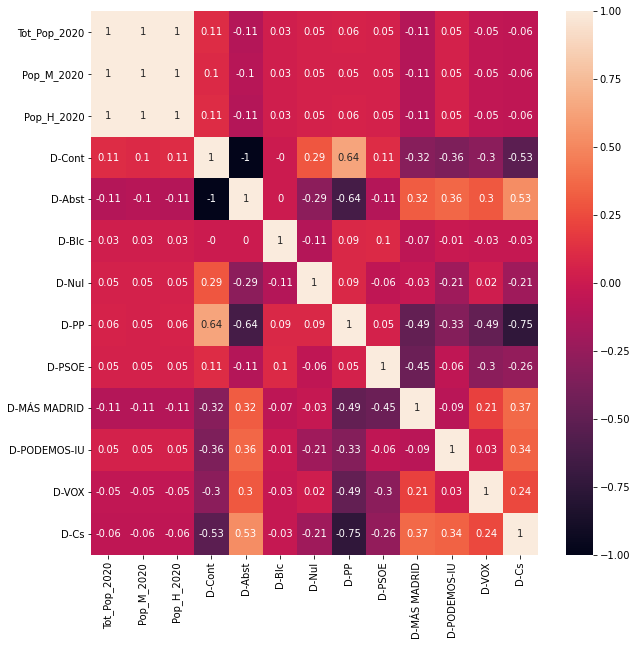

In [6]:

import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(df_muni_D,columns=['Tot_Pop_2020', 'Pop_M_2020', 'Pop_H_2020', 'D-Cont', 'D-Abst', 'D-Blc', 'D-Nul', 'D-PP', 'D-PSOE', 'D-MÁS MADRID', 'D-PODEMOS-IU', 'D-VOX', 'D-Cs'])

corrMatrix = round(df.corr(), 2)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sn.heatmap(corrMatrix, annot=True)
#plt.figure(figsize=(20, 15))
plt.show()


In [7]:
df_muni_D.describe()

,CP,Tot_Pop_2020,Pop_M_2020,Pop_H_2020,D-Cont,D-Abst,D-Blc,D-Nul,D-PP,D-PSOE,D-MÁS MADRID,D-PODEMOS-IU,D-VOX,D-Cs
count,176.000000,1.760000e+02,1.760000e+02,1.760000e+02,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,28091.426136,3.823593e+04,1.994462e+04,1.829131e+04,3.988409,-3.988523,0.081364,-0.108693,20.048750,-11.742443,4.471136,1.107955,1.024205,-13.934205
std,53.732302,2.532070e+05,1.351191e+05,1.180941e+05,5.926230,5.926119,0.585118,0.508462,6.613136,3.679365,2.943365,1.677404,2.344449,4.930221
min,28001.000000,4.900000e+01,1.900000e+01,3.000000e+01,-15.890000,-14.390000,-2.370000,-1.890000,1.910000,-21.620000,-7.610000,-3.830000,-7.610000,-26.980000
25%,28044.750000,9.750000e+02,4.822500e+02,4.962500e+02,0.607500,-8.907500,-0.082500,-0.257500,15.727500,-13.690000,2.852500,0.295000,-0.412500,-16.757500
50%,28090.500000,4.122000e+03,2.041000e+03,2.051500e+03,5.120000,-5.120000,0.110000,0.000000,21.350000,-11.400000,4.020000,0.960000,0.940000,-14.580000
75%,28137.250000,1.336700e+04,6.714250e+03,6.626250e+03,8.907500,-0.607500,0.310000,0.142500,24.675000,-9.790000,5.535000,1.722500,2.512500,-11.057500
max,28183.000000,3.334730e+06,1.780831e+06,1.553899e+06,14.390000,15.890000,3.450000,1.790000,35.090000,1.420000,22.370000,8.990000,8.500000,0.000000


In [44]:
df_muni_D.sort_values('D-PP')

,CP,Municipio,Tot_Pop_2020,Pop_M_2020,Pop_H_2020,D-Cont,D-Abst,D-Blc,D-Nul,D-PP,D-PSOE,D-MÁS MADRID,D-PODEMOS-IU,D-VOX,D-Cs
38,28039,Cervera de Buitrago,162,65,97,-6.68,6.68,0.03,0.07,1.91,-20.59,22.37,-1.54,3.20,-4.50
111,28117,Prádena del Rincón,125,55,70,-8.42,8.42,-2.37,1.01,2.03,-13.22,7.71,2.27,4.90,-5.57
19,28020,Berzosa del Lozoya,222,96,126,10.85,-10.85,-0.17,0.00,2.14,1.42,3.86,-2.41,-1.90,-5.72
151,28159,Valdemaqueda,775,378,397,-2.21,2.21,0.42,-0.59,3.15,-13.82,7.83,3.21,8.50,-7.88
76,28078,Madarcos,49,19,30,-1.01,1.01,0.00,0.00,3.65,-6.92,3.52,8.99,-0.76,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,28066,Griñón,10435,5224,5211,11.20,-11.20,0.41,-0.10,31.07,-8.92,2.78,0.06,-2.29,-21.90
153,28161,Valdemoro,77270,39128,38142,9.59,-9.59,0.35,0.07,31.31,-10.97,2.37,1.50,-2.85,-20.96
14,28015,Arroyomolinos,32935,16516,16419,12.70,-12.70,0.35,0.07,31.37,-10.25,2.35,-0.96,-1.46,-20.53
169,28177,Villanueva del Pardillo,17396,8934,8462,6.72,-6.72,0.26,-0.03,33.43,-9.10,2.08,0.16,-2.58,-22.72
